In [28]:
from konlpy.tag import Okt
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
df =pd.read_csv('d:/data/project/review.csv',encoding='ms949')[:50000]
df.head()

,Rating,Review
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...


In [3]:
df['Review'] = df['Review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
df[:5]

C:\Users\tjoeun707\AppData\Local\Temp\ipykernel_10660\1111432611.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review'] = df['Review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')


,Rating,Review
0,1,숙성돼지고기전문점입니다건물모양때문에매장모양도좀특이하지만쾌적한편이고살짝레트로감성으로분...
1,1,고기가정말맛있었어요육즙이가득있어서너무좋았아요일하시는분들너무친절하고좋습니다가격이조금있...
2,1,잡내없고깔끔담백한맛의순댓국이순댓국을안좋아하는사람들에게도술술넘어갈듯합니다정식메뉴를시키...
3,1,고기양이푸짐해서특순대국밥을시킨기분이듭니다맛도좋습니다다만양념장이득뿍있어서간이약간짤수도...
4,1,순댓국자체는제가먹어본순대국밥집중에서안에는들어요그러나밥양이적은점공깃밥자체가맛나지만은않...


In [4]:
df['Review'].replace('',np.nan, inplace=True)
print(df.isnull().sum())

Rating     0
Review    20
dtype: int64


In [5]:
df.loc[df.Review.isnull()][:5]

,Rating,Review
1419,1,NaN
1516,1,NaN
1649,1,NaN
2733,1,NaN
3242,1,NaN


In [6]:
df = df.dropna(how = 'any')

In [7]:
X=df[['Review']]
y= df['Rating']

In [8]:
X_sample , y_sample = RandomUnderSampler(random_state=0).fit_resample(X,y)
X_samp = pd.DataFrame(data =X_sample,columns=['Review'])
y_samp = pd.DataFrame(data = y_sample,columns=['Rating'])
df_samp = pd.concat([X_samp, y_samp], axis=1)

In [9]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
okt = Okt()
X = []
y = []
for idx, sentence in enumerate(df_samp['Review']):
    temp = []
    temp = okt.morphs(sentence,stem = True)
    temp = [word for word in temp if not word in stopwords]
    X.append(temp) 
    y.append(df_samp.iloc[idx,1])   

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [12]:
i = 0
for word in list(tokenizer.word_index.keys()):
    print(word, ' ==>', tokenizer.word_index[word])
    i+=1
    if i >5:
        break

먹다  ==> 1
맛  ==> 2
맛있다  ==> 3
좋다  ==> 4
을  ==> 5
이다  ==> 6


In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기: ',total_cnt)
print('출현 빈도가 %s번 이하인 회귀 단어의 수: %s'%(threshold-1,rare_cnt))
print('단어 집합에서 회귀 단어의 비율: ',(rare_cnt / total_cnt)*100)

단어 집합(vocabulary)의 크기:  15508
출현 빈도가 2번 이하인 회귀 단어의 수: 8823
단어 집합에서 회귀 단어의 비율:  56.89321640443642


In [14]:
vocab_size = total_cnt - rare_cnt +1
print('단어 집합의 크기: ',vocab_size)

단어 집합의 크기:  6686


In [15]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
i = 0
for word in list(tokenizer.word_index.keys()):
    print(word, ' ==>', tokenizer.word_index[word])
    i+=1
    if i >5:
        break

먹다  ==> 1
맛  ==> 2
맛있다  ==> 3
좋다  ==> 4
을  ==> 5
이다  ==> 6


In [16]:
X2 = tokenizer.texts_to_sequences(X)


In [17]:
for index, sentence in enumerate(X2[:10]):
    print(index, sentence)

0 [25, 4737, 102, 170, 51, 1024, 5, 644, 355, 1669, 24, 51, 386, 8, 33, 431, 504, 18, 42, 34, 2157, 2, 708]
1 [1113, 118, 21, 2, 56, 260, 145, 1085, 896, 245, 562, 24, 1514, 1372, 896, 131, 563, 171, 496, 444, 99, 530, 4738, 80, 2984, 312, 2]
2 [531, 220, 18, 97, 913, 210, 564, 1086, 828, 238, 932]
3 [478, 48, 74, 556, 53, 52, 22, 239, 5512, 7, 12, 118, 470, 39, 1025]
4 [426, 4739, 650, 2383, 102, 1613, 1, 178, 223, 32, 1, 57, 72, 20, 1995, 11, 53, 398, 2384, 2985, 1, 709, 41, 2, 1560, 76, 4, 168, 28, 460, 695, 186, 2158, 256, 207, 3811, 423, 1995, 1, 50, 1024, 3490, 1157, 1252, 4200, 579, 25, 1, 352, 204, 1515, 30, 7, 4201, 36, 11, 467, 365, 204, 1515, 365, 783, 3490, 1157, 42, 23, 4201, 20, 3490, 784, 283, 1614, 22, 365, 1042, 637, 4740, 5513, 1561, 410, 1, 352, 33, 481, 3812, 365, 2073, 8, 674, 1615, 16, 4, 142, 674, 3813, 432, 948, 1615, 3814, 389, 1042, 4741, 2498, 30, 1616, 1995, 768, 178, 220, 365, 1042, 474, 5, 1270, 16, 276, 36, 38, 381, 77, 21, 22, 3490, 1157, 10, 223, 186, 1

In [18]:
drop_X = [index for index, sentence in enumerate(X2) if len(sentence) < 1]
drop_X[:10]

[]

In [19]:
X_text = np.delete(X, drop_X, axis=0)
X = np.delete(X2, drop_X, axis=0)
y = np.delete(y, drop_X,axis=0)

d:\anaconda\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이: 308
리뷰의 평균 길이: 32.68432671081678


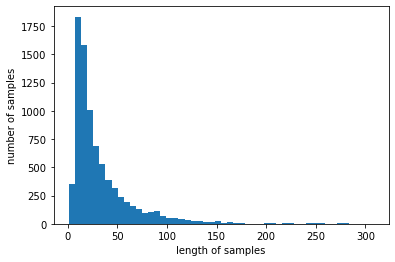

In [20]:
max_len=max(len(l) for l in X)
print('리뷰의 최대 길이:',max_len) 
print('리뷰의 평균 길이:',sum(map(len, X))/len(X)) 
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
X = sequence.pad_sequences(X, maxlen = max_len)
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y, random_state=10)

In [23]:
y_samp.value_counts()

Rating
0         2718
1         2718
2         2718
dtype: int64

In [24]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [25]:
#스케일링시 점수가 더 떨어짐
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# pd.DataFrame(X_train_scaled).boxplot()

# X_train_scaled = pd.DataFrame(X_train_scaled)
# X_test_scaled = pd.DataFrame(X_test_scaled)

In [30]:
np.random.seed(0)
number_of_features = 100
features, target = make_classification(n_samples = 10000,n_features = number_of_features,n_informative = 3,n_redundant = 0,n_classes = 3,weights = [.5, .5],random_state = 10)
def create_model(optimizers='rmsprop'):
    model = Sequential()
    model.add(Embedding(vocab_size, 100))
    model.add(LSTM(128)) 
    model.add(Dense(3, activation='softmax',name='output'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
neural_network = KerasClassifier(build_fn=create_model,epochs=10,batch_size=128,verbose=0)
cross_val_score(neural_network, features, target, cv=3)

C:\Users\tjoeun707\AppData\Local\Temp\ipykernel_10660\897593431.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasClassifier(build_fn=create_model,epochs=10,batch_size=128,verbose=0)


array([0.5074985, 0.5019502, 0.4848485])

In [31]:
epochs = [5, 10]
batches = [5, 10, 100]
optimizers = ["rmsprop", "adam"]
hyperparameters = dict(optimizer=optimizers, epochs=epochs,batch_size=batches)
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)
grid_result = grid.fit(features, target)
grid_result.best_params_

ValueError: optimizer is not a legal parameter

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, 100))
# model.add(LSTM(128)) 
# model.add(Dense(3, activation='softmax',name='output'))
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
hist = create_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2,verbose=1)

In [ ]:
scores=create_model.evaluate(X_test, y_test[:X_test.shape[0]],verbose=0)
print(scores)

In [ ]:
plt.plot(hist.history['loss']) 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss']) 
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.grid()
plt.show()